# 4. Корреляционный анализ и оценка значимости признаков

Итак, мы провели предобработку данных, произвели очистку от выбросов, провели небольшой разведывательный анализ данных, а также с помощью статистических тестов проверили некоторые из своих гипотез.  

Настало время закодировать полученные признаки и приступить к центральному моменту нашего проекта - моделированию предсказания стоимости объекта недвижимости. Напомним, с какими данными имеем дело:  

**Описание объекта недвижимости**  

`status` — текущий статус объекта на продажу;  
`type` — тип объекта недвижимости;  
`sqft` — площадь объекта в квадратных футах;  
`stories` — количество этажей;  
`baths` — количество ванных комнат;  
`beds` — количество спален;   
`pool` - наличие бассейна;  
`acres` - размер участка земли как приложение к дому;  
`built` - год постройки объекта;  
`remodeled` - факт обновления объекта (реставрация, плановый ремонт).
  
**Благоустройство**  

`heating` - факт подключения объекта к системе отопления;   
`parking` - наличие парковки;  
`is_garage` - наличие гаража;  

**Привлекательность района**

`avg_rating_school` - средний рейтинг близлежащих школ (по 10-бальной школе);  
`avg_distance_school` - среднее расстояние до школы;  
`has_pk` - имеются ли подготовительные курсы к школе (для поступающих детей - дошколят)

**Географическая информация**  
   
`state` — штат;  
`city` - город или район расположения объекта;  
`zipcode` - почтовый индекс

**Целевой фактор**
  
`target` — цена объекта недвижимости (его и будем прогнозировать).  

Импортируем необходимые для работы библиотеки:

In [1]:
import numpy as np # матричные вычисления
import pandas as pd # чтение и работа с датафреймом

import matplotlib.pyplot as plt # визуализация
%matplotlib inline
import seaborn as sns
import plotly
import plotly.io as pio
pio.renderers.default='png' # рендеринг plotly визуализаций
import plotly.express as px

from sklearn import preprocessing # предобработка данных

from sklearn.feature_selection import f_classif, chi2 # стат тесты

from sklearn.model_selection import train_test_split # разделение выборки

from sklearn.linear_model import LinearRegression, RidgeCV # линейные модели

from sklearn.tree import DecisionTreeRegressor # деревья решений

from sklearn import ensemble # ансамблевые модели

import xgboost as xgb # экстремальный градиентный бустинг

import optuna # оптимизация гиперпараметров

from sklearn import metrics # расчет метрик

Прочитаем данные:

In [2]:
data = pd.read_csv("data/realty_data.csv")
data.head()

,status,type,zipcode,state,city,sqft,stories,baths,beds,heating,parking,is_garage,pool,acres,avg_rating_school,avg_distance_school,has_pk,built,remodeled,target
0,contingent,single-family,28387.0,NC,Southern Pines,2900.0,1.0,3.0,4.0,yes,yes,False,no,0.00,5.2,5.54,1,2019.0,no,418000.0
1,for sale,single-family,99216.0,WA,Spokane Valley,1947.0,2.0,3.0,3.0,no,yes,False,no,0.13,4.0,1.33,1,2019.0,no,310000.0
2,for sale,single-family,90049.0,CA,Los Angeles,3000.0,1.0,2.0,3.0,yes,yes,True,yes,0.20,6.7,1.96,0,1961.0,yes,2895000.0
3,contingent,other,34759.0,FL,Poinciana,1507.0,1.0,2.0,3.0,yes,yes,False,no,0.11,2.3,3.83,1,2006.0,yes,181500.0
4,contingent,single-family,50401.0,IA,Mason City,3588.0,1.0,2.0,3.0,yes,yes,False,no,2.86,3.8,6.35,1,1970.0,no,244900.0


Сделаем копию датасета:

In [3]:
train_data = data.copy()

Основное достоинство логарифмирования - это то, что оно уменьшает разброс значений и приводит распределение близко к нормальному, поэтому применим логарифм к количественным признакам и будем обучать модель на них:

In [4]:
# список признаков с положительными значениями
columns_to_log = ['sqft', 'stories', 'avg_rating_school']

# признаки с нулевыми значениями
columns_with_nulls = ['baths', 'beds', 'acres', 'avg_distance_school']

train_data[columns_to_log] = train_data[columns_to_log].apply(lambda x: np.log(x))
train_data[columns_with_nulls] = train_data[columns_with_nulls].apply(lambda x: np.log1p(x))

Заменим значения бинарных столбцов строковыми, чтобы они могли отображаться как категориальные:

In [5]:
# словари для замены значений в признаках
cat_garage = {False: 'no', True: 'yes'}
cat_pk = {0: 'no', 1: 'yes'}

train_data['is_garage'] = train_data['is_garage'].map(cat_garage)
train_data['has_pk'] = train_data['has_pk'].map(cat_pk)

Выведем описательную статистику категориальных признаков:

In [6]:
train_data.describe(include='object')

,status,type,state,city,heating,parking,is_garage,pool,has_pk,remodeled
count,271765,271765,271765,271765,271765,271765,271765,271765,271765,271765
unique,6,8,35,1551,2,2,2,2,2,2
top,for sale,single-family,FL,Houston,yes,yes,no,no,yes,no
freq,183394,172873,84232,18609,209117,270902,189481,238234,209563,149689


Признаки `state` и `city` содержат большое количество категорий, поэтому закодируем их при помощи `LabelEncoder`. Также не стоит забывать про почтовый индекс объекта - хотя мы и преобразовали его в числовой на начальном этапе работы с датасетом, по факту он также является категориальным, поскольку сразу несколько объектов по своему местоположению могут относиться к одному и тому же индексу. Это также относится к признаку года постройки здания `built`: 

In [7]:
train_data['zipcode'] = train_data['zipcode'].astype('str')
train_data['built'] = train_data['built'].astype('str')

# создание экземпляра класса LabelEncoder()
lab_enc = preprocessing.LabelEncoder()

# кодирование признаков
train_data['state_label'] = lab_enc.fit_transform(train_data['state'])
train_data['zipcode_label'] = lab_enc.fit_transform(train_data['zipcode'])
train_data['city_label'] = lab_enc.fit_transform(train_data['city'])
train_data['built_label'] = lab_enc.fit_transform(train_data['built'])

# удаляем исходные столбцы
train_data.drop(['state', 'zipcode', 'city', 'built'], axis=1, inplace=True)

Категориальные столбцы с небольшим количеством категорий и булевы признаки закодируем, применив к ним `OneHotEncoder`:

In [8]:
# создание экземпляра класса OneHotEncoder()
one_hot_encoder = preprocessing.OneHotEncoder()

# признаки на преобразование
cat_features_to_change = ['status', 'type', 'heating', 'parking', 
                          'is_garage', 'pool', 'has_pk', 'remodeled']

# перевод закодированного датафрейма в массив
data_onehot = one_hot_encoder.fit_transform(train_data[cat_features_to_change]).toarray()

# получение списка закодированных признаков
column_names = one_hot_encoder.get_feature_names_out()

# создание датафрейма из закодированных признаков
data_onehot = pd.DataFrame(data_onehot, columns=column_names)

print("Количество новых бинарных признаков: {:.0f}".format(data_onehot.shape[1]))

# соединяем датафреймы и избавляемся от исходных признаков
train_data = pd.concat(
    [train_data.reset_index(drop=True).drop(cat_features_to_change, axis=1), data_onehot], 
    axis=1
)

Количество новых бинарных признаков: 26


Сформируем матрицу наблюдений `Х`, вектор целевой переменной `y` и его логарифмированную версию `y_log`. Модель будем обучать именно на логарифмированной версии:

In [9]:
X = train_data.drop(['target'], axis=1)
y = train_data['target']
y_log = np.log(train_data['target'])

Инициализируем списки получившихся непрерывных и категориальных признаков для оценки значимости:

In [10]:
# непрерывные и дискретные признаки
num_cols = ['sqft', 'stories', 'baths', 'beds', 'acres', 
            'avg_rating_school', 'avg_distance_school']

# категориальные признаки
cat_cols = ['state_label', 'zipcode_label', 'city_label', 
            'status_coming soon', 'status_contingent', 
            'status_contract', 'status_for sale', 
            'status_foreclosure', 'status_pending', 
            'built_label', 'type_apartments', 'type_condo', 
            'type_mobile', 'type_multi-family', 'type_other', 
            'type_ranch', 'type_single-family', 'type_townhouse', 
            'heating_no', 'heating_yes', 'parking_no', 'parking_yes', 
            'is_garage_no', 'is_garage_yes', 'pool_no', 'pool_yes', 
            'has_pk_no', 'has_pk_yes', 'remodeled_no', 'remodeled_yes']

Проверим дискретные и непрерывные признаки на мультиколлинеарность между собой, а также оценим степень значимости признаков на целевую переменную:

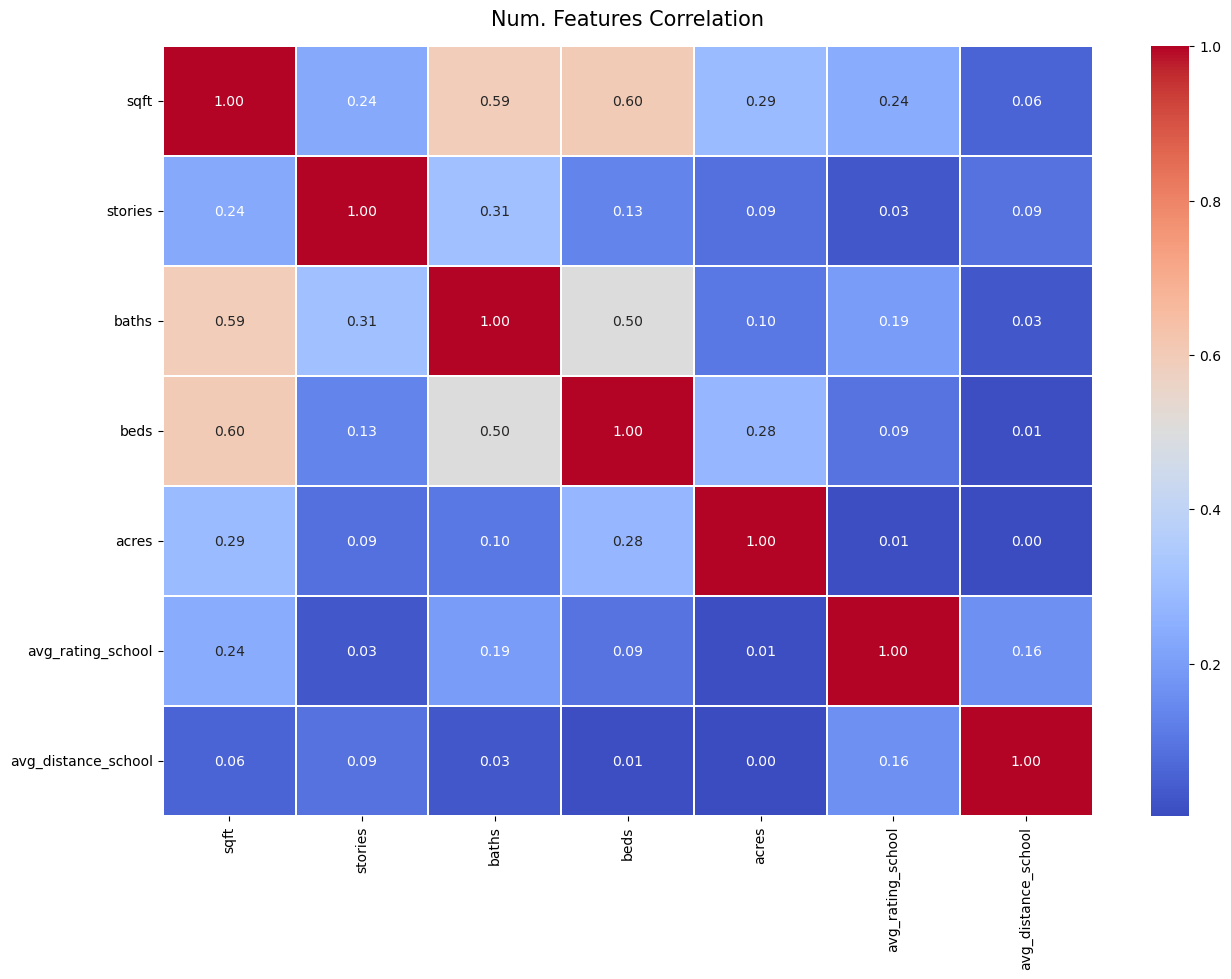

In [11]:
fig, ax = plt.subplots(figsize=(15, 10))

# визуализация хитмэпа по методу Спирмена
corr_num_matrix = X[num_cols].corr(method='spearman').abs()

sns.heatmap(corr_num_matrix, annot=True, linewidths=0.3, 
    ax=ax,  cmap='coolwarm', fmt='.2f')

ax.set_title('Num. Features Correlation', fontsize=15, pad=15);

Мультиколлинеарность отсутствует. Наиболее сильная взаимосвязь между собой демонстрируют пары `sqft`-`baths` и `sqft`-`beds`, однако это не повлияет на ухудшение прогноза.  

С помощью  функции `f_classif` на основе ANOVA-теста оценим значимость признаков на целевой фактор:

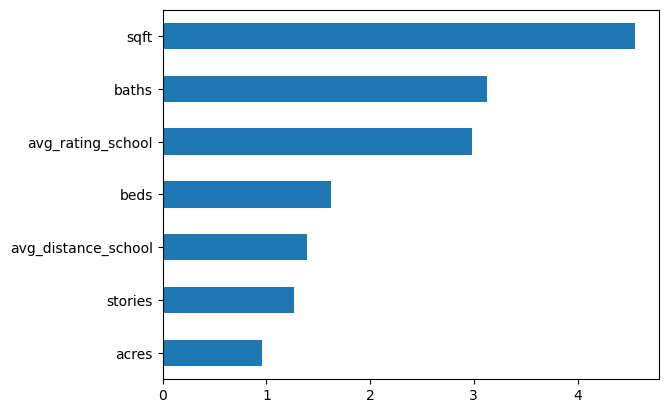

In [12]:
# оценка значимости непрерывных и дискретных признаков
y_int = y.astype('int')
imp_num = pd.Series(f_classif(X[num_cols], y)[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh');

Признак квадратных футов объекта является фактором, которой оказывает самое мощное влияние на формирование цены объекта недвижимости.  

Теперь проверим корреляции в категориальных признаках. Поскольку наши данные не имеют нормального распределения, также будем использовать метод Спирмена:

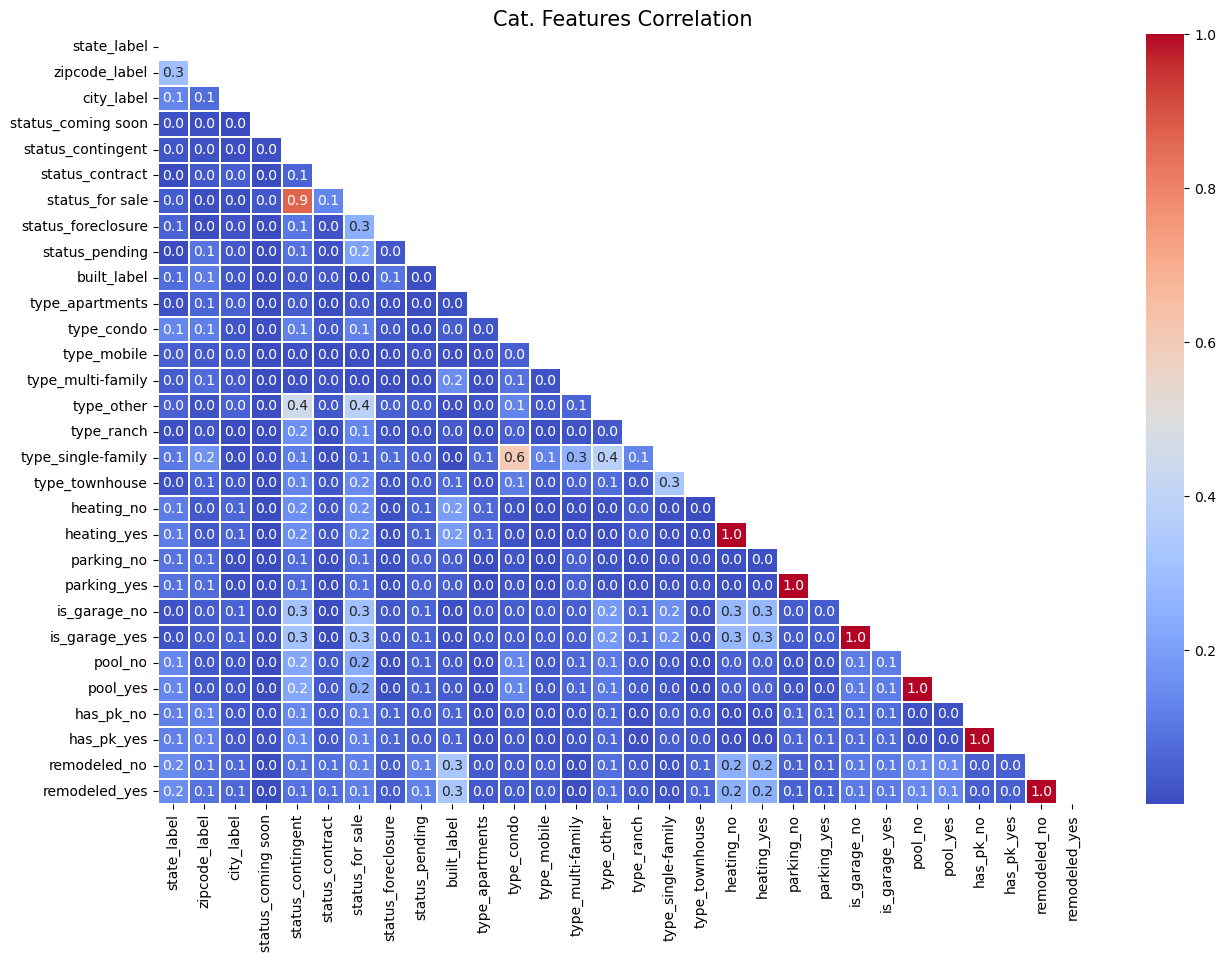

In [13]:
fig, ax = plt.subplots(figsize=(15, 10))

corr_cat_matrix = X[cat_cols].corr(method='spearman').abs()
matrix = np.triu(X[cat_cols].corr(method='spearman'))

sns.heatmap(corr_cat_matrix, 
            annot=True, 
            linewidths=0.3, 
            ax=ax, 
            mask=matrix, 
            cmap='coolwarm',
            fmt='.1f')

ax.set_title('Cat. Features Correlation', fontsize=15)

plt.show()

Видим мультиколлинеарность в паре `status_for sale` - `status_contingent` и в бинарных категориях, извлеченных из столбцов `heating`, `parking`, `is_garage`, `pool`, `has_pk` и `remodeled`. Чтобы понять, какой из пары признаков менее значимый для нашего таргета, воспользуемся результатами теста хи-квадрат:

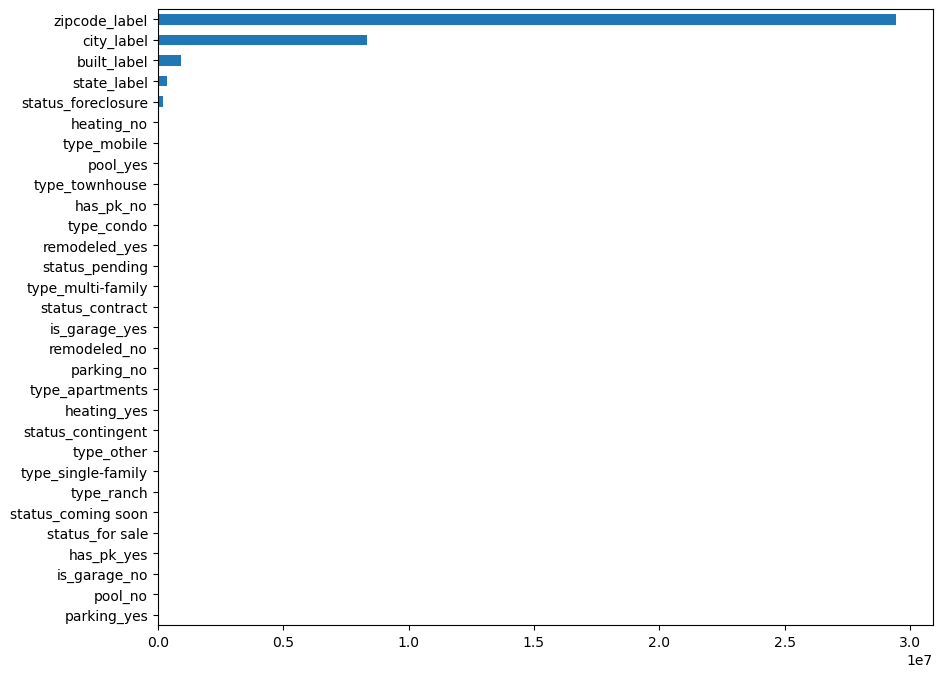

In [14]:
# хи-квадрат, оценка значимости категориальных переменных
imp_cat = pd.Series(chi2(X[cat_cols], y_int)[0], index=cat_cols)
imp_cat.sort_values(inplace = True)
fig, ax = plt.subplots(figsize=(10, 8))
imp_cat.plot(kind = 'barh', ax=ax)
plt.show()

Среди категориальных факторов признак почтового индекса оказался наиболее значим для целевой переменной.  

Воспользуемся результатами теста и удалим наименее значимые признаки для таргета из пары мультикоррелированных:

In [15]:
train_data.drop(['status_contingent', 'remodeled_no', 'heating_yes', 'parking_yes', 
                 'is_garage_no', 'pool_no', 'has_pk_yes'], axis=1, inplace=True)

> Удаление признаков выше в данном случае никак не влияет на итоговые метрики, но мы избавились от них по правилам мультиколлинеарности. 

Поскольку наши данные содержат более 270 тыс. строк, будем использовать `hold-out` валидацию. Разобьем выборку на тренировочную и тестовую в соотношении 70 на 30:

In [16]:
X_train, X_test, y_train_log, y_test_log = train_test_split(
    X, y_log, 
    test_size=0.3, 
    random_state=42
)

Мы готовы к этапу моделирования!

# 5. Baseline и решение задачи регрессии
### 5.1. Линейная регрессия (базовая модель)

In [17]:
# создаём объект класса LinearRegression
lr_model = LinearRegression()

# обучаем модель - ищем параметры МНК
lr_model.fit(X_train, y_train_log)

# делаем предсказания
y_train_pred = lr_model.predict(X_train)
y_test_pred = lr_model.predict(X_test)

# выводим метрики
print('Train MSE: {:.2f}'.format(metrics.mean_squared_error(y_train_log, y_train_pred)))
print('Test MSE: {:.2f}'.format(metrics.mean_squared_error(y_test_log, y_test_pred)))
print('Train MAE: {:.2f}'.format(metrics.mean_absolute_error(y_train_log, y_train_pred)))
print('Test MAE: {:.2f}'.format(metrics.mean_absolute_error(y_test_log, y_test_pred)))
print('Train R2: {:.2f}'.format(metrics.r2_score(y_train_log, y_train_pred)))
print('Test R2: {:.2f}'.format(metrics.r2_score(y_test_log, y_test_pred)))

Train MSE: 0.37
Test MSE: 0.37
Train MAE: 0.46
Test MAE: 0.46
Train R2: 0.44
Test R2: 0.44


Переобучение отсутствует, однако модель демонстрирует слабую предсказательную способность. Метрики `MSE` (среднеквадратичная ошибка) и `MAE` (средняя абсолютная ошибка) чем меньше, тем лучше. Коэффициент детерминации `R2` улавливает только 44% всех взаимосвязей в данных.  

Попробуем более сложные модели.

### 5.2. Полиномиальная регрессия

In [18]:
# Создаём генератор полиномиальных признаков
poly = preprocessing.PolynomialFeatures(degree = 2, include_bias = False)
poly.fit(X_train)

# генерируем полиномиальные признаки
X_train_poly = poly.transform(X_train)
X_test_poly = poly.transform(X_test)

# создаем модель для полиномиальной регрессии
lr_poly = LinearRegression()

# обучаем модель по МНК
lr_poly.fit(X_train_poly, y_train_log)

# делаем предсказания для каждой из выборок
y_train_pred = lr_poly.predict(X_train_poly)
y_test_pred = lr_poly.predict(X_test_poly)

# вывод метрик
print('Train MSE: {:.2f}'.format(metrics.mean_squared_error(y_train_log, y_train_pred)))
print('Test MSE: {:.2f}'.format(metrics.mean_squared_error(y_test_log, y_test_pred)))
print('Train MAE: {:.2f}'.format(metrics.mean_absolute_error(y_train_log, y_train_pred)))
print('Test MAE: {:.2f}'.format(metrics.mean_absolute_error(y_test_log, y_test_pred)))
print('Train R2: {:.2f}'.format(metrics.r2_score(y_train_log, y_train_pred)))
print('Test R2: {:.2f}'.format(metrics.r2_score(y_test_log, y_test_pred)))

Train MSE: 0.22
Test MSE: 0.22
Train MAE: 0.35
Test MAE: 0.35
Train R2: 0.66
Test R2: 0.66


Обучение на полиномах второй степени позволило модели уловить долю дисперсии зависимой переменной в 66%, среднеквадратичная и абсолютная ошибка также уменьшили свои значения. Переобучение не наблюдается, однако есть потенциал улучшения качества прогнозирования по каждому из показателей. Можно было бы попробовать увеличить степень полиномов, однако существующих ресурсов на построение такой модели недостаточно, о чем свидетельствует полученная ошибка типа `Memory Error`.  

Попробуем более сложные модели.

### 5.3. Деревья решений

In [19]:
# строим модель дерева решений
dt_reg = DecisionTreeRegressor(random_state = 42)
dt_reg.fit(X_train, y_train_log)

# делаем предсказания
y_train_pred = dt_reg.predict(X_train)
y_test_pred = dt_reg.predict(X_test)

# вывод метрик
print('Train MSE: {:.2f}'.format(metrics.mean_squared_error(y_train_log, y_train_pred)))
print('Test MSE: {:.2f}'.format(metrics.mean_squared_error(y_test_log, y_test_pred)))
print('Train MAE: {:.2f}'.format(metrics.mean_absolute_error(y_train_log, y_train_pred)))
print('Test MAE: {:.2f}'.format(metrics.mean_absolute_error(y_test_log, y_test_pred)))
print('Train R2: {:.2f}'.format(metrics.r2_score(y_train_log, y_train_pred)))
print('Test R2: {:.2f}'.format(metrics.r2_score(y_test_log, y_test_pred)))

Train MSE: 0.00
Test MSE: 0.16
Train MAE: 0.00
Test MAE: 0.24
Train R2: 1.00
Test R2: 0.75


Итак, мы получили переобучение модели. Параметры были выставлены по умолчанию, поэтому попробуем перебрать глубину дерева решений для улучшения показателей модели. В качестве целевой метрики возьмем коэффициент детерминации на тестовой выборке, который будем стремиться максимизировать:

Оптимальная глубина дерева решений: 18
 R2  на тренировочной выборке: 0.90
 R2  на тестовой выборке: 0.77



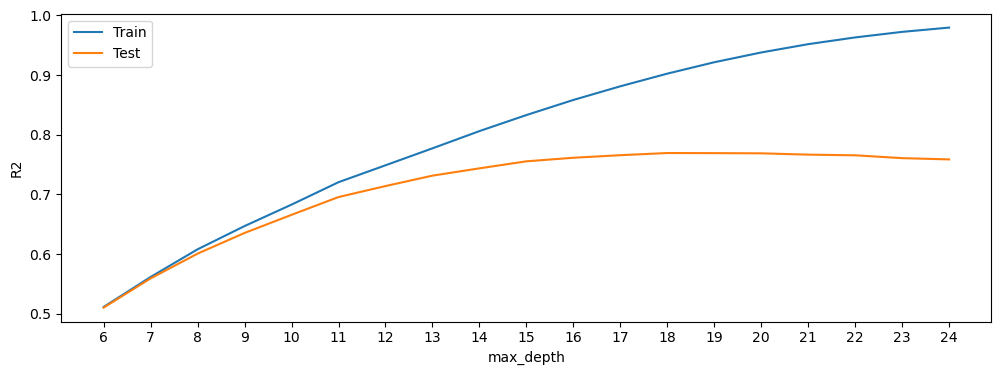

In [20]:
max_depths = range(6, 25)

# списки результатов по каджой выборке
train_scores = []
test_scores = []

for depth in max_depths:
    dt_reg = DecisionTreeRegressor(max_depth = depth, random_state = 42)
    dt_reg.fit(X_train, y_train_log)
    y_train_pred = dt_reg.predict(X_train)
    y_test_pred = dt_reg.predict(X_test)
    
    # расчет метрик
    train_scores.append(
        metrics.r2_score(y_train_log, y_train_pred)
    )
    test_scores.append(
        metrics.r2_score(y_test_log, y_test_pred)
    )
    
# визуализация результатов
fig, ax = plt.subplots(figsize = (12, 4))
ax.plot(max_depths, train_scores, label = 'Train') 
ax.plot(max_depths, test_scores, label = 'Test') 
ax.set_xlabel('max_depth')                         
ax.set_ylabel('R2')                           
ax.set_xticks(max_depths)                         
ax.legend();

best_index = test_scores.index(max(test_scores))

print('Оптимальная глубина дерева решений: {:.0f}\n'.format(max_depths[best_index]),
      'R2  на тренировочной выборке: {:.2f}\n'.format(train_scores[best_index]),
      'R2  на тестовой выборке: {:.2f}\n'.format(test_scores[best_index]))

Построим модель с выбранной глубиной и оценим оставшиеся метрики:

In [21]:
# строим модель дерева решений
dt_reg = DecisionTreeRegressor(random_state = 42, max_depth=18)
dt_reg.fit(X_train, y_train_log)

# делаем предсказания
y_train_pred = dt_reg.predict(X_train)
y_test_pred = dt_reg.predict(X_test)

# вывод метрик
print('Train MSE: {:.2f}'.format(metrics.mean_squared_error(y_train_log, y_train_pred)))
print('Test MSE: {:.2f}'.format(metrics.mean_squared_error(y_test_log, y_test_pred)))
print('Train MAE: {:.2f}'.format(metrics.mean_absolute_error(y_train_log, y_train_pred)))
print('Test MAE: {:.2f}'.format(metrics.mean_absolute_error(y_test_log, y_test_pred)))
print('Train R2: {:.2f}'.format(metrics.r2_score(y_train_log, y_train_pred)))
print('Test R2: {:.2f}'.format(metrics.r2_score(y_test_log, y_test_pred)))

Train MSE: 0.06
Test MSE: 0.15
Train MAE: 0.16
Test MAE: 0.25
Train R2: 0.90
Test R2: 0.77


Уже лучше! Однако небольшая доля переобучения все же присутствует. Попробуем более сложные ансамблевые модели.  

### 5.4. Случайный лес

In [22]:
# модель случайного леса
rf_reg = ensemble.RandomForestRegressor(
    n_estimators = 100,
    max_depth = 18,
    random_state = 42,
    n_jobs = -1
)

# обучаем модель
rf_reg.fit(X_train, y_train_log)

# делаем предсказания
y_train_pred = rf_reg.predict(X_train)
y_test_pred = rf_reg.predict(X_test)

# вывод метрик
print('Train MSE: {:.2f}'.format(metrics.mean_squared_error(y_train_log, y_train_pred)))
print('Test MSE: {:.2f}'.format(metrics.mean_squared_error(y_test_log, y_test_pred)))
print('Train MAE: {:.2f}'.format(metrics.mean_absolute_error(y_train_log, y_train_pred)))
print('Test MAE: {:.2f}'.format(metrics.mean_absolute_error(y_test_log, y_test_pred)))
print('Train R2: {:.2f}'.format(metrics.r2_score(y_train_log, y_train_pred)))
print('Test R2: {:.2f}'.format(metrics.r2_score(y_test_log, y_test_pred)))

Train MSE: 0.05
Test MSE: 0.10
Train MAE: 0.15
Test MAE: 0.21
Train R2: 0.92
Test R2: 0.85


Пока что `RandomForest` - фаворит среди всех построенных моделей. Модель сумела уловить 85% информации на тестовой выборке, разница между метриками ошибок также незначительна.  

### 5.5. Стекинг  

Попробуем увеличить точность предсказания с помощью объединения нескольких базовых моделей. Ими будут выступать линейная регрессия с l2-регуляризацией и деревья решений. В качестве мета-модели возьмем случайный лес, который будет формировать окончательный прогноз:

In [23]:
# cоздаем список кортежей вида: (наименование модели, модель)
estimators = [
    ('lr', RidgeCV()),
    ('dt', DecisionTreeRegressor(random_state=42))
]

# создаем объект класса стекинг
reg = ensemble.StackingRegressor(
    estimators=estimators,
    final_estimator=ensemble.RandomForestRegressor(
        n_estimators=100,
        random_state=42
    )
)

# обучаем модель
reg.fit(X_train, y_train_log)

StackingRegressor(estimators=[('lr', RidgeCV()),
                              ('dt', DecisionTreeRegressor(random_state=42))],
                  final_estimator=RandomForestRegressor(random_state=42))

Обучение провели, теперь сформируем предсказания и выведем метрики:

In [24]:
y_train_pred_stack = reg.predict(X_train)
y_test_pred_stack = reg.predict(X_test)

# вывод метрик
print('Train MSE: {:.2f}'.format(metrics.mean_squared_error(y_train_log, y_train_pred_stack)))
print('Test MSE: {:.2f}'.format(metrics.mean_squared_error(y_test_log, y_test_pred_stack)))
print('Train MAE: {:.2f}'.format(metrics.mean_absolute_error(y_train_log, y_train_pred_stack)))
print('Test MAE: {:.2f}'.format(metrics.mean_absolute_error(y_test_log, y_test_pred_stack)))
print('Train R2: {:.2f}'.format(metrics.r2_score(y_train_log, y_train_pred_stack)))
print('Test R2: {:.2f}'.format(metrics.r2_score(y_test_log, y_test_pred_stack)))

Train MSE: 0.06
Test MSE: 0.17
Train MAE: 0.16
Test MAE: 0.28
Train R2: 0.91
Test R2: 0.74


Метрики хуже по сравнению с обычной моделью случайного леса, переобучение выше.  

### 5.6. Экстремальный бустинг

In [25]:
xgb_model = xgb.XGBRegressor(
    max_depth=5, # глубина
    learning_rate=0.2, # темп обучения
    n_estimators=800 # кол-во моделей
)

cl = xgb_model.fit(X_train, y_train_log)

y_train_pred = cl.predict(X_train)
y_test_pred = cl.predict(X_test)

print('Train MSE: {:.2f}'.format(metrics.mean_squared_error(y_train_log, y_train_pred)))
print('Test MSE: {:.2f}'.format(metrics.mean_squared_error(y_test_log, y_test_pred)))
print('Train MAE: {:.2f}'.format(metrics.mean_absolute_error(y_train_log, y_train_pred)))
print('Test MAE: {:.2f}'.format(metrics.mean_absolute_error(y_test_log, y_test_pred)))
print('Train R2: {:.2f}'.format(metrics.r2_score(y_train_log, y_train_pred)))
print('Test R2: {:.2f}'.format(metrics.r2_score(y_test_log, y_test_pred)))

Train MSE: 0.07
Test MSE: 0.09
Train MAE: 0.18
Test MAE: 0.20
Train R2: 0.90
Test R2: 0.87


Получилась очень сбалансированная и устойчивая модель. Метрики по сравнению со случайным лесом улучшились, коэффициент детерминации показывает долю улавливаемой дисперсии в 87%.  

Попробуем последнюю модель.  

### 5.7. Градиентный бустинг над деревьями решений

In [26]:
gb_reg = ensemble.GradientBoostingRegressor(
    n_estimators = 100,
    max_depth = 18,
    random_state = 42
)

# обучаем модель
gb_reg.fit(X_train, y_train_log)

# делаем предсказания
y_train_pred = gb_reg.predict(X_train)
y_test_pred = gb_reg.predict(X_test)

print('Train MSE: {:.2f}'.format(metrics.mean_squared_error(y_train_log, y_train_pred)))
print('Test MSE: {:.2f}'.format(metrics.mean_squared_error(y_test_log, y_test_pred)))
print('Train MAE: {:.2f}'.format(metrics.mean_absolute_error(y_train_log, y_train_pred)))
print('Test MAE: {:.2f}'.format(metrics.mean_absolute_error(y_test_log, y_test_pred)))
print('Train R2: {:.2f}'.format(metrics.r2_score(y_train_log, y_train_pred)))
print('Test R2: {:.2f}'.format(metrics.r2_score(y_test_log, y_test_pred)))

Train MSE: 0.00
Test MSE: 0.08
Train MAE: 0.02
Test MAE: 0.17
Train R2: 1.00
Test R2: 0.88


Переобучение очевидно, метрики максимальны на тренировочной выборке. Однако, в целом показатели выглядят многообещающе. Попробуем провести оптимизацию гиперпараметров. Использовать будем `Optuna`:

In [27]:
def optuna_gb(trial):
    """Реализует подбор оптимальных гиперпараметров модели
    градиентного бустинга при помощи библиотеки Optuna    
    """ 
    # задаем пространства поиска гиперпараметров
    n_estimators = trial.suggest_int('n_estimators', 100, 221, 1)
    max_depth = trial.suggest_int('max_depth', 5, 12, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 5, 1)
    
    # создаем модель
    model = ensemble.GradientBoostingRegressor(
        n_estimators=n_estimators, 
        max_depth=max_depth, 
        min_samples_leaf=min_samples_leaf, 
        random_state=42
    )
    
    # обучаем модель
    model.fit(X_train, y_train_log)
    
    # расчет метрики MAE
    score = metrics.mean_absolute_error(y_train_log, model.predict(X_train))
    
    return score

Ищем лучшую комбинацию гиперпараметров. В качестве целевой метрики будем максимизировать среднюю абсолютную ошибку:

In [28]:
%%time
study = optuna.create_study(study_name="GradientBoostingRegressor", direction="minimize")

# ищем лучшую комбинацию гиперпараметров 20 раз
study.optimize(optuna_gb, n_trials=20)

[I 2023-11-02 17:43:11,075] A new study created in memory with name: GradientBoostingRegressor
[I 2023-11-02 17:45:39,626] Trial 0 finished with value: 0.17999673766161853 and parameters: {'n_estimators': 134, 'max_depth': 9, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.17999673766161853.
[I 2023-11-02 17:47:43,197] Trial 1 finished with value: 0.22943503571363957 and parameters: {'n_estimators': 157, 'max_depth': 6, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.17999673766161853.
[I 2023-11-02 17:49:44,941] Trial 2 finished with value: 0.21526793372748795 and parameters: {'n_estimators': 135, 'max_depth': 7, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.17999673766161853.
[I 2023-11-02 17:54:22,814] Trial 3 finished with value: 0.11837702896764969 and parameters: {'n_estimators': 204, 'max_depth': 11, 'min_samples_leaf': 3}. Best is trial 3 with value: 0.11837702896764969.
[I 2023-11-02 17:58:58,225] Trial 4 finished with value: 0.10376073279434393 and paramet

CPU times: total: 1h 10min 51s
Wall time: 1h 11min 5s


Выведем полученные результаты:

In [29]:
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("MAE на обучающем наборе: {:.2f}".format(study.best_value))

Наилучшие значения гиперпараметров {'n_estimators': 220, 'max_depth': 12, 'min_samples_leaf': 2}
MAE на обучающем наборе: 0.09


Изучим историю оптимизации наших гиперпараметров:

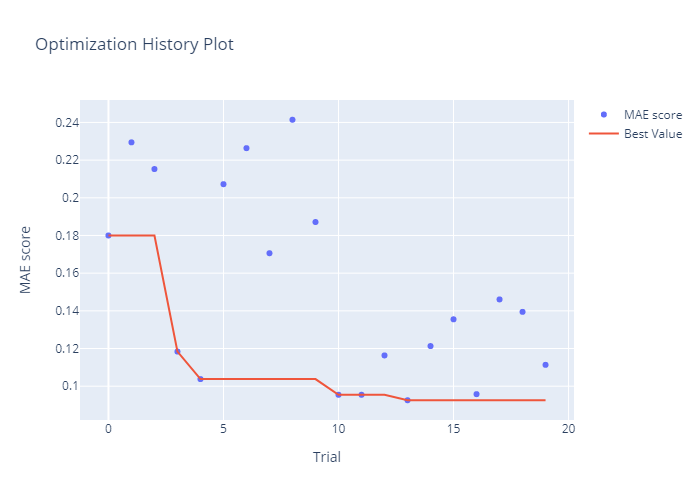

In [30]:
optuna.visualization.plot_optimization_history(study, target_name="MAE score")

Видим, что метрика двигалась в правильном направлении в сторону уменьшения.  

Посмотрим, какие гиперпараметры вносят наиболее весомый вклад в минимизацию метрики:

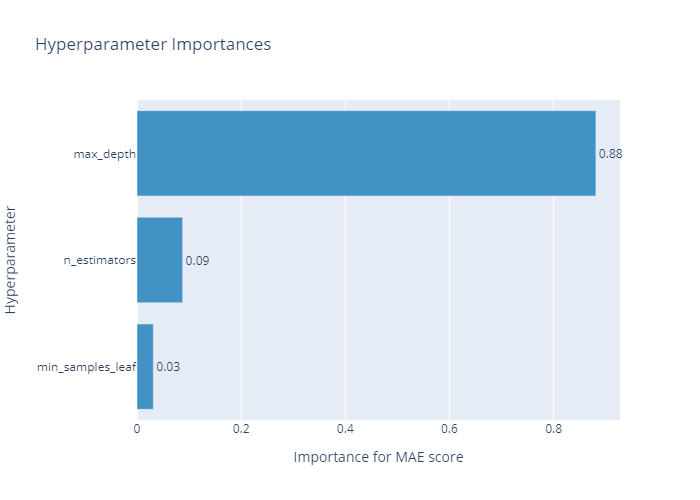

In [31]:
optuna.visualization.plot_param_importances(study, target_name="MAE score")

Больше всего внимания стоит уделять настройке глубины дерева. Однако здесь следует быть осторожным, поскольку слишком высокое значение `max_depth` гарантированно приведет к переобучению.

Чтобы оценить связь комбинации гиперпараметров со значением оптимизируемой метрики, построим контурный график:

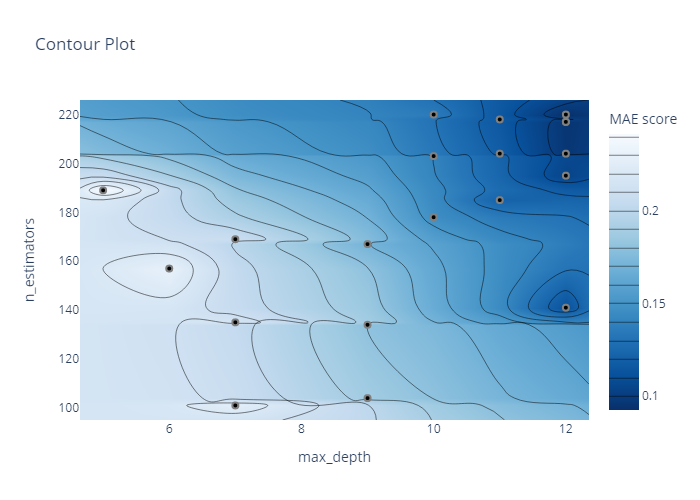

In [32]:
optuna.visualization.plot_contour(study, params=["max_depth", "n_estimators"],
                                  target_name="MAE score")

Самое низкое значение метрики на синем фоне и есть оптимальное сочетание гиперпараметров.  

Наконец, построим обновленную модель градиентного бустинга и оценим значения метрик:

In [33]:
gb_mod_reg = ensemble.GradientBoostingRegressor(
    n_estimators = 220,
    max_depth = 12, 
    min_samples_leaf = 2,
    random_state = 42
)

# обучаем модель
gb_mod_reg.fit(X_train, y_train_log)

# делаем предсказания
y_train_pred = gb_mod_reg.predict(X_train)
y_test_pred = gb_mod_reg.predict(X_test)

print('Train MSE: {:.2f}'.format(metrics.mean_squared_error(y_train_log, y_train_pred)))
print('Test MSE: {:.2f}'.format(metrics.mean_squared_error(y_test_log, y_test_pred)))
print('Train MAE: {:.2f}'.format(metrics.mean_absolute_error(y_train_log, y_train_pred)))
print('Test MAE: {:.2f}'.format(metrics.mean_absolute_error(y_test_log, y_test_pred)))
print('Train R2: {:.2f}'.format(metrics.r2_score(y_train_log, y_train_pred)))
print('Test R2: {:.2f}'.format(metrics.r2_score(y_test_log, y_test_pred)))

Train MSE: 0.02
Test MSE: 0.07
Train MAE: 0.09
Test MAE: 0.17
Train R2: 0.97
Test R2: 0.90


В качестве интерпретируемой метрики возьмем медианную абсолютную ошибку и преобразуем ее значение из логарифмического масштаба в нормальный вид:

In [34]:
y_test = np.exp(y_test_log)
y_test_pred_exp = np.exp(y_test_pred)
meae_test = metrics.median_absolute_error(y_test, y_test_pred_exp)
print('MeAE на тестовой выборке: {:.0f} $'.format(meae_test))

MeAE на тестовой выборке: 33080 $


Напомним, что в наших данных присутствует недвижимость, стоимость которой колеблется в диапазоне от 8,900 до 50,000,000 млн. $.  

Систематизируем результаты моделирования:

In [35]:
data = {'Metric': ['Train MSE', 'Test MSE', 'Train MAE', 'Test MAE', 'Train R2', 'Test R2'], 
        'LinearRegression': [0.37, 0.37, 0.46, 0.46, 0.44, 0.44], 
        'PolynomialRegression': [0.22, 0.22, 0.35, 0.35, 0.66, 0.66], 
        'DecisionTree': [0.06, 0.15, 0.16, 0.25, 0.9, 0.77], 
        'RandomForest': [0.05, 0.1, 0.15, 0.21, 0.92, 0.85], 
        'Stacking': [0.06, 0.17, 0.16, 0.28, 0.91, 0.74],
        'GradientBoosting': [0.02, 0.07, 0.09, 0.17, 0.97, 0.9],
        'XGBoost': [0.07, 0.09, 0.18, 0.2, 0.9, 0.87]}

df_metric = pd.DataFrame(data)
df_metric

,Metric,LinearRegression,PolynomialRegression,DecisionTree,RandomForest,Stacking,GradientBoosting,XGBoost
0,Train MSE,0.37,0.22,0.06,0.05,0.06,0.02,0.07
1,Test MSE,0.37,0.22,0.15,0.10,0.17,0.07,0.09
2,Train MAE,0.46,0.35,0.16,0.15,0.16,0.09,0.18
3,Test MAE,0.46,0.35,0.25,0.21,0.28,0.17,0.20
4,Train R2,0.44,0.66,0.90,0.92,0.91,0.97,0.90
5,Test R2,0.44,0.66,0.77,0.85,0.74,0.90,0.87


### Подведем итоги  

1. Данная задача простыми линейными моделями не решается. В ходе экспериментов мы задействовали и ансамблевые модели, и стекинг, градиентный и экстремальный бустинг. Подбор гиперпараметров при помощи байесовского метода оптимизации и `Optuna` помог улучшить модель градиентного бустинга по всем параметрам. Несмотря на то, что данная модель ресурсозатратная по сравнению с `XGBoost`, она показывает наиболее низкие ошибки на тестовой выборке и высокий коэффициент детерминации.  


2. Модель экстремального бустинга - наиболее устойчивая и шустрая модель, отлично работающая с большими объемами данных. Кроме того, ее очевидным преимуществом является автоматическая обработка категориальных признаков. В данном ноутбуке входные данные уже были предобработаны в единый для каждой модели вид, поэтому мы не стали заново загружать датасет.

3. Модель случайного леса также удивила своей сбалансированностью. Как и в случае с экстремальным бустингом существует гипотетическая вероятность также "поднять" качество метрик при помощи подбора гиперпараметров. Однако следует помнить о глубине деревьев - если увлечься, то можно получить переобучение и при оптимальных гиперпараметрах, поэтому при прочих равных условиях стоит отдавать предпочтение моделям с наименьшей глубиной.  

4. Исходя из всех полученных результатов, на текущий момент модель градиентного бустинга выходит победителем из этого соревнования. С помощью нее получена средняя абсолютная ошибка со значением 0.17, что оказалось недостижимым для всех остальных моделей. В задачах бизнеса следует выбирать модели с наилучшей предсказательной и обобщающей способностью. Однако существует пространство для маневров и не исключено, что при помощи подбора гиперпараметров ошибка на экстремальном бустинге также уменьшится.